In [10]:
import os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F, torchaudio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [11]:
SR = 16_000
N_MELS = 128
CLIP_SEC = 3  # pad/trim to 3 s so every sample has at least this length
MAX_LEN = SR * CLIP_SEC


class AudioDataset(Dataset):
    def __init__(self, root, train=True, time_mask=30, freq_mask=13):
        paths, labels = [], []
        for cls, lab in (("others", 0), ("questions", 1)):
            p = os.path.join(root, cls)
            if not os.path.isdir(p):
                continue
            for f in os.listdir(p):
                if f.lower().endswith(".wav"):  # add more extensions if needed
                    paths.append(os.path.join(p, f))
                    labels.append(lab)
        self.paths, self.labels = paths, labels
        self.train = train
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SR, n_fft=1024, hop_length=512, n_mels=N_MELS
        )
        self.to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)
        if train:
            self.fmask = torchaudio.transforms.FrequencyMasking(
                freq_mask_param=freq_mask
            )
            self.tmask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        w, sr = torchaudio.load(self.paths[idx])
        if w.numel() == 0:  # empty / corrupt → silence
            w = torch.zeros(1, MAX_LEN)
            sr = SR
        w = w.mean(0, keepdim=True)  # mono
        if sr != SR:
            w = torchaudio.functional.resample(w, sr, SR)
        if w.size(1) < MAX_LEN:
            w = F.pad(w, (0, MAX_LEN - w.size(1)))
        else:
            w = w[:, :MAX_LEN]
        spec = self.to_db(self.mel(w))  # [1, n_mels, T]
        if self.train:
            spec = self.fmask(self.tmask(spec))
        return spec, self.labels[idx]

In [12]:
def pad_collate(batch):
    specs, labels = zip(*batch)
    max_T = max(s.shape[2] for s in specs)
    specs_padded = [F.pad(s, (0, max_T - s.shape[2])) for s in specs]
    return torch.stack(specs_padded), torch.tensor(labels)

In [13]:
train_root, test_root = "cleaned_dataset/train", "cleaned_dataset/test"

full_train_ds = AudioDataset(train_root, train=True)
train_idx, val_idx = train_test_split(
    np.arange(len(full_train_ds)),
    test_size=0.2,
    stratify=full_train_ds.labels,
    random_state=42,
)

train_ds = torch.utils.data.Subset(full_train_ds, train_idx)
val_ds = torch.utils.data.Subset(full_train_ds, val_idx)
test_ds = AudioDataset(test_root, train=False)

batch = 16
train_loader = DataLoader(
    train_ds, batch, shuffle=True, collate_fn=pad_collate, drop_last=True
)
val_loader = DataLoader(val_ds, batch, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_ds, batch, shuffle=False, collate_fn=pad_collate)

print(f"train {len(train_ds)}, val {len(val_ds)}, test {len(test_ds)}")

train 8218, val 2055, test 7145


In [14]:
y_train = [full_train_ds.labels[i] for i in train_idx]
pos_weight = torch.tensor([y_train.count(0) / max(1, y_train.count(1))], device=device)
print("pos_weight:", pos_weight.item())
label_smooth = 0.05

pos_weight: 1.28024423122406


In [15]:
class Net(nn.Module):
    def __init__(self, drop=0.3):
        super().__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(drop),
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(drop),
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.Dropout(drop)
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.c3(self.c2(self.c1(x)))
        x = self.gap(x).view(x.size(0), -1)
        return self.fc(x)


model = Net().to(device)
print("params:", sum(p.numel() for p in model.parameters()) / 1e3, "K")

params: 23.585 K


In [16]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=2
)
mixup_alpha = 0.4
patience = 5
best_loss = float("inf")
no_improve = 0
history = {"trL": [], "vaL": [], "trA": [], "vaA": []}

In [17]:
def smooth(y):
    return y * (1 - label_smooth) + 0.5 * label_smooth


for epoch in range(30):
    # ---- train ----
    model.train()
    tl, tc, tn = 0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).float()
        # mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        idx = torch.randperm(xb.size(0)).to(device)
        xb = lam * xb + (1 - lam) * xb[idx]
        yb = lam * yb + (1 - lam) * yb[idx]
        yb_s = smooth(yb)
        opt.zero_grad()
        out = model(xb).squeeze()
        loss = criterion(out, yb_s)
        loss.backward()
        opt.step()
        tl += loss.item() * xb.size(0)
        preds = (torch.sigmoid(out) >= 0.5).float()
        tc += (preds == yb.round()).sum().item()
        tn += xb.size(0)
    trL, trA = tl / tn, tc / tn

    # ---- validate ----
    model.eval()
    vl, vc, vn = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).float()
            out = model(xb).squeeze()
            loss = criterion(out, smooth(yb))
            vl += loss.item() * xb.size(0)
            preds = (torch.sigmoid(out) >= 0.5).float()
            vc += (preds == yb).sum().item()
            vn += xb.size(0)
    vaL, vaA = vl / vn, vc / vn
    sched.step(vaL)

    history["trL"].append(trL)
    history["vaL"].append(vaL)
    history["trA"].append(trA)
    history["vaA"].append(vaA)
    print(f"Ep{epoch+1:02d} | TL {trL:.3f} VA {vaL:.3f} | TA {trA:.2f} VA {vaA:.2f}")

    if vaL < best_loss - 1e-4:
        best_loss, no_improve = vaL, 0
        best_wts = model.state_dict()
    else:
        no_improve += 1
    if no_improve >= patience:
        print("early stop")
        break

model.load_state_dict(best_wts)

Ep01 | TL 0.760 VA 0.736 | TA 0.60 VA 0.63
Ep02 | TL 0.756 VA 0.750 | TA 0.61 VA 0.63
Ep03 | TL 0.750 VA 0.739 | TA 0.61 VA 0.62
Ep04 | TL 0.749 VA 0.728 | TA 0.62 VA 0.64
Ep05 | TL 0.747 VA 0.737 | TA 0.62 VA 0.65
Ep06 | TL 0.740 VA 0.755 | TA 0.63 VA 0.64
Ep07 | TL 0.738 VA 0.709 | TA 0.63 VA 0.67
Ep08 | TL 0.733 VA 0.760 | TA 0.64 VA 0.64
Ep09 | TL 0.729 VA 0.784 | TA 0.64 VA 0.62
Ep10 | TL 0.727 VA 0.687 | TA 0.65 VA 0.70
Ep11 | TL 0.721 VA 0.793 | TA 0.66 VA 0.62
Ep12 | TL 0.715 VA 0.727 | TA 0.66 VA 0.67
Ep13 | TL 0.713 VA 0.772 | TA 0.65 VA 0.64
Ep14 | TL 0.699 VA 0.954 | TA 0.68 VA 0.60
Ep15 | TL 0.701 VA 0.805 | TA 0.68 VA 0.63
early stop


<All keys matched successfully>

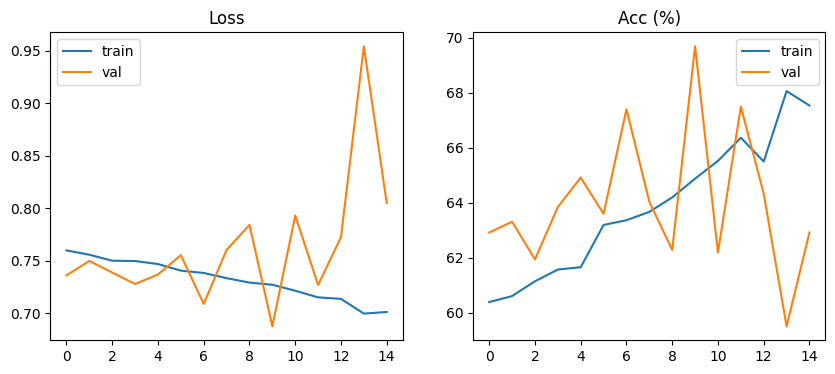

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["trL"], label="train")
plt.plot(history["vaL"], label="val")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.array(history["trA"]) * 100, label="train")
plt.plot(np.array(history["vaA"]) * 100, label="val")
plt.title("Acc (%)")
plt.legend()
plt.show()

test acc: 86.03%
              precision    recall  f1-score   support

      others       0.88      0.97      0.92      6042
   questions       0.61      0.26      0.37      1103

    accuracy                           0.86      7145
   macro avg       0.74      0.62      0.64      7145
weighted avg       0.84      0.86      0.84      7145



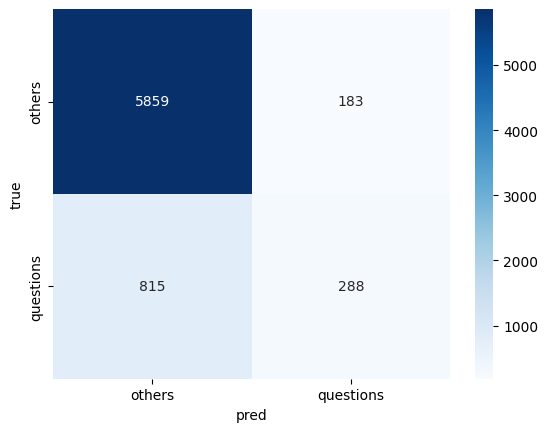

In [19]:
model.eval()
preds, gts = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb.to(device)).squeeze()
        preds += (torch.sigmoid(out) >= 0.5).long().cpu().tolist()
        gts += yb.tolist()

preds, gts = np.array(preds), np.array(gts)
acc = (preds == gts).mean() * 100
print(f"test acc: {acc:.2f}%")
print(classification_report(gts, preds, target_names=["others", "questions"]))
cm = confusion_matrix(gts, preds)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["others", "questions"],
    yticklabels=["others", "questions"],
)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()